ECE 8803 - Final Project

In [1]:
!pip install --user datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("gOLIVES/OLIVES_Dataset", "biomarker_detection", cache_dir="./scratch/huggingface_datasets")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

In [3]:
import numpy as np
from PIL import Image

# adjusing contrast of the image
def adjust_image(image, contrast_factor=1.2, brightness_offset=30):
    """
    Adjusts the image contrast and brightness.
    
    Parameters:
        image (PIL.Image.Image): Input image in grayscale
        contrast_factor (float): Multiplicative factor to enhance contrast.
        brightness_offset (float): Constant to add for brightness adjustment.
        
    Returns:
        np.ndarray: Adjusted image as a NumPy array with dtype uint8.
    """
    
    arr = np.array(image).astype(np.float32)
    
    # brightness offset and contrast factor manipulate array
    adjusted_arr = arr * contrast_factor + brightness_offset
    
    # stay in valid range
    adjusted_arr = np.clip(adjusted_arr, 0, 255)
    
    return adjusted_arr.astype(np.uint8)


In [4]:
import itertools
import pandas as pd
import numpy as np
from IPython.display import display

train_samples = ds["train"]
df = pd.DataFrame(train_samples)

# drop empty rows
df_clean = df.dropna(subset=["B1", "B2", "B3", "B4", "B5", "B6"])

# get X and y
X = df_clean["Image"]
y = df_clean[["B1", "B2", "B3", "B4", "B5", "B6"]]

# apply image pre-processing
X = X.apply(lambda img: adjust_image(img, contrast_factor=1.2, brightness_offset=20))

print("Cleaned Feature (X) sample (as NumPy arrays):")
print(X.head())

print("\nCleaned Target (y) sample:")
print(y.head())

print("Minimum value in y:", y.values.min())
print("Maximum value in y:", y.values.max())

print(len(X))
print(len(y))

# 6468 at 30000
# 8428 at 40000
# 11613 at 50000
# 17591 at 80000

Cleaned Feature (X) sample (as NumPy arrays):
0    [[20, 39, 29, 20, 23, 22, 27, 36, 28, 20, 20, ...
1    [[20, 39, 29, 20, 23, 22, 27, 36, 28, 20, 20, ...
2    [[24, 21, 21, 34, 48, 24, 20, 20, 28, 51, 33, ...
3    [[24, 21, 21, 34, 48, 24, 20, 20, 28, 51, 33, ...
4    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
Name: Image, dtype: object

Cleaned Target (y) sample:
    B1   B2   B3   B4   B5   B6
0  1.0  0.0  1.0  1.0  0.0  1.0
1  1.0  0.0  1.0  1.0  0.0  1.0
2  1.0  0.0  1.0  1.0  0.0  0.0
3  1.0  0.0  1.0  1.0  0.0  0.0
4  1.0  0.0  1.0  0.0  0.0  0.0
Minimum value in y: 0.0
Maximum value in y: 1.0
17591
17591


In [5]:
import itertools
import pandas as pd
import numpy as np
from IPython.display import display

test_samples = ds["test"]
df_test = pd.DataFrame(test_samples)

# drop rows
df_test_clean = df_test.dropna(subset=["B1", "B2", "B3", "B4", "B5", "B6"])

# extract X and y
X_test = df_test_clean["Image"]
y_test = df_test_clean[["B1", "B2", "B3", "B4", "B5", "B6"]]

# image preprocessing
X_test = X_test.apply(lambda img: adjust_image(img, contrast_factor=1.2, brightness_offset=20))

print("Test Feature (X_test) sample (as NumPy arrays):")
print(X_test.head())

print("\nTest Target (y_test) sample:")
print(y_test.head())

print("\nRange of test targets:")
print("Minimum value in y:", y_test.values.min())
print("Maximum value in y:", y_test.values.max())


Test Feature (X_test) sample (as NumPy arrays):
0    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
1    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
2    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
3    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
4    [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, ...
Name: Image, dtype: object

Test Target (y_test) sample:
    B1   B2   B3   B4   B5   B6
0  0.0  0.0  1.0  1.0  0.0  0.0
1  0.0  0.0  1.0  0.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0
3  0.0  0.0  1.0  0.0  0.0  0.0
4  0.0  0.0  1.0  0.0  0.0  0.0

Range of test targets:
Minimum value in y: 0.0
Maximum value in y: 1.0


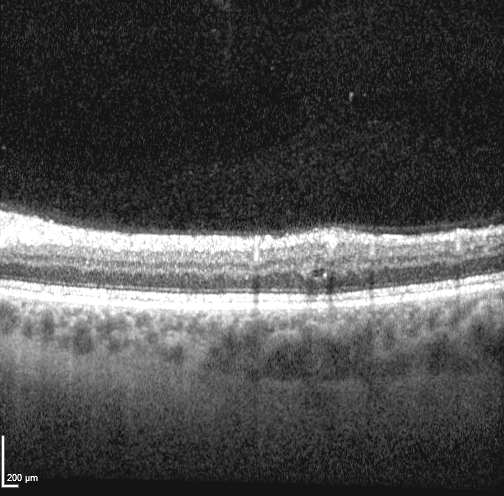

In [6]:
# image display example
display(Image.fromarray(X[0]))


In [32]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# unnormalized transform
basic_transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),   # yields C×H×W in [0,1]
])

dataset_nn = BiomarkerDataset(X, y, transform=basic_transform)
loader_nn  = DataLoader(dataset_nn, batch_size=32, shuffle=False, num_workers=4)

# accumulate
chan_sum   = torch.zeros(3)
chan_sqsum = torch.zeros(3)
num_pixels = 0

# loop to get mean and std
for imgs, _ in loader_nn:
    b, c, h, w = imgs.shape
    num_pixels += b * h * w

    # sum over batch and spatial dims
    chan_sum   += imgs.sum(dim=[0,2,3])
    chan_sqsum += (imgs ** 2).sum(dim=[0,2,3])

# final mean and std
mean = chan_sum   / num_pixels
var  = (chan_sqsum / num_pixels) - (mean ** 2)
std  = torch.sqrt(var)

print("Dataset mean:", mean.tolist())
print("Dataset std: ", std.tolist())


Dataset mean: [0.27961495518684387, 0.27961495518684387, 0.27961495518684387]
Dataset std:  [0.252422571182251, 0.252422571182251, 0.252422571182251]


In [33]:
from torchvision import transforms

maxvit_transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.27961495518684387, 0.27961495518684387, 0.27961495518684387],
        std=[0.252422571182251, 0.252422571182251, 0.252422571182251],
    ),
])


In [35]:
# dataloader

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class BiomarkerDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X.iloc[idx]
        img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.y.iloc[idx].astype(np.float32))
        return img, label

      
      
#----------------------------------#
train_batch_size = 32
test_batch_size = 1

train_dataset = BiomarkerDataset(X, y, transform=maxvit_transform)
trainloader  = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

test_dataset  = BiomarkerDataset(X_test, y_test, transform=maxvit_transform)
testloader   = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

for inputs, targets in trainloader:
    print("Batch of inputs has shape:", inputs.shape)
    print("Batch of targets has shape:", targets.shape)
    break


Batch of inputs has shape: torch.Size([32, 3, 518, 518])
Batch of targets has shape: torch.Size([32, 6])


In [9]:
# Install timm if you haven’t already
!pip install --user timm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import timm
print(timm.list_models('*dinov2*'))

['vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_giant_patch14_dinov2', 'vit_giant_patch14_reg4_dinov2', 'vit_large_patch14_dinov2', 'vit_large_patch14_reg4_dinov2', 'vit_small_patch14_dinov2', 'vit_small_patch14_reg4_dinov2']


In [40]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# ---- 1) Device -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- 2) Model --------------------------------------------------------------
model = timm.create_model(
    "vit_small_patch14_dinov2",   # DINOv2 backbone
    pretrained=True,
    num_classes=6                 # six biomarker logits
)
model.to(device)

# ---- 3) Loss & Optimiser ---------------------------------------------------
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ---- 4) Training loop ------------------------------------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    sample_count = 0
    next_report = 100

    for inputs, targets in trainloader:
        # expand grayscale to RGB if necessary
        if inputs.shape[1] == 1:
            inputs = inputs.repeat(1, 3, 1, 1)

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)           # logits → (B,6)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item() * inputs.size(0)

        # update and report samples
        sample_count += inputs.size(0)
        if sample_count >= next_report:
            print(f"  [Epoch {epoch+1}] processed {sample_count} samples so far")
            next_report += 1000

    epoch_loss = running_loss / len(trainloader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Final Loss: {epoch_loss:.4f}")


Using device: cuda
  [Epoch 1] processed 128 samples so far
  [Epoch 1] processed 1120 samples so far
  [Epoch 1] processed 2112 samples so far
  [Epoch 1] processed 3104 samples so far
  [Epoch 1] processed 4128 samples so far
  [Epoch 1] processed 5120 samples so far
  [Epoch 1] processed 6112 samples so far
  [Epoch 1] processed 7104 samples so far
  [Epoch 1] processed 8128 samples so far
  [Epoch 1] processed 9120 samples so far
  [Epoch 1] processed 10112 samples so far
  [Epoch 1] processed 11104 samples so far
  [Epoch 1] processed 12128 samples so far
  [Epoch 1] processed 13120 samples so far
  [Epoch 1] processed 14112 samples so far
  [Epoch 1] processed 15104 samples so far
  [Epoch 1] processed 16128 samples so far
  [Epoch 1] processed 17120 samples so far
[Epoch 1/10] Final Loss: 0.1872
  [Epoch 2] processed 128 samples so far
  [Epoch 2] processed 1120 samples so far
  [Epoch 2] processed 2112 samples so far
  [Epoch 2] processed 3104 samples so far
  [Epoch 2] process

In [41]:
# Final evaluation on test set
from sklearn.metrics import f1_score
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(device)
        if inputs.shape[1] == 1:
            inputs = inputs.repeat(1, 3, 1, 1)
        targets = targets.to(device).float()

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(targets.cpu().numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

macro_f1 = f1_score(all_labels, all_preds, average='macro')
per_class_f1 = f1_score(all_labels, all_preds, average=None)

print(f"Test macro-F1: {macro_f1:.4f}")
for i, f1c in enumerate(per_class_f1, 1):
    print(f"  Class B{i} F1: {f1c:.4f}")

# dinov2 - 20 epochs - 0.5163

Test macro-F1: 0.5163
  Class B1 F1: 0.5612
  Class B2 F1: 0.4919
  Class B3 F1: 0.7959
  Class B4 F1: 0.4154
  Class B5 F1: 0.3536
  Class B6 F1: 0.4801
